## NetOPS Cádiz

#### This is the code and the workflow to show what can be achieved with netops_cadiz python library processing ASD field spectometer data

In [2]:
import os
import pandas as pd
import numpy as np
import specdal
import matplotlib.pyplot as plt

class asd():

    def __init__(self, sensores, spec_path, sat):

        """Start the class creating an asd object

        Args:
            sensores (table): path to the provided excel file with the Spectral Response Functions stored_
            spec_path (path): Path to the folder whre spectrum files are stored
            sat (String): Satellite selected to get the expected bands values
        """

        self.sensores = sensores
        self.spec_path = spec_path
        self.sats = { 'S2A': ['MSI', 1, 'blue'],'S2B': ['MSI', 2, 'green'],'L8': ['OLI', 3, 'red'],'L9': ['OLI', 4, 'purple'],'L7': ['ETM+', 7, 'orange'],
                     'L5': ['TM', 6, 'brown'], 'L4': ['TM', 5, 'pink'], 'SQ': ['Sequoia', 8, 'olive']}
        self.sensors = {'MSI': {"B1": [np.arange(412, 457), 443, 'Coastal blue'], "B2": [np.arange(456, 534), 490, 'Blue'], "B3": [np.arange(538, 584), 560, 'Green'], 
                                "B4": [np.arange(646, 685), 665, 'Red'], "B5": [np.arange(695, 715), 705, 'Red edge 1'], "B6": [np.arange(731, 760), 740, 'Red edge 2'], 
                                "B7": [np.arange(769, 798), 783, 'Red edge 3'], "B8": [np.arange(760, 908), 842, 'Nir'], "B8A": [np.arange(837, 882), 865, 'Nir 8A'], 
                                "B9": [np.arange(932, 959), 945, 'Water vapour'], "B10": [np.arange(1337, 1413), 1375, 'Cirrus'], "B11": [np.arange(1539, 1683), 1610, 'Swir 1'], 
                                "B12": [np.arange(2078, 2321), 2190, 'Swir 2']},
                        'OLI': {"B1": [np.arange(435, 451), 443, 'Coastal blue'], "B2": [np.arange(452, 512), 482, 'Blue'], "B3": [np.arange(533, 590), 562, 'Green'], 
                                "B8": [np.arange(503, 676), 590, 'Pan'], "B4": [np.arange(636, 673), 655, 'Red'], "B5": [np.arange(851, 879), 865, 'Nir'], 
                                "B9": [np.arange(1363, 1384), 1374, 'Cirrus'], "B6": [np.arange(1566, 1651), 1609, 'Swir 1'], "B7": [np.arange(2107, 2294), 2200, 'Swir 2']},
                        'ETM+': {"B1": [np.arange(441, 514), 478, 'Blue'], "B2": [np.arange(519, 601), 560, 'Green'], "B3": [np.arange(631, 692), 662, 'Red'], 
                                 "B4": [np.arange(772, 898), 835, 'Nir'], "B5": [np.arange(1547, 1749), 1648, 'Swir 1'], "B7": [np.arange(2064, 2345), 2205, 'Swir 2']},
                        'TM': {"B1": [np.arange(441, 514), 478, 'Blue'], "B2": [np.arange(519, 601), 560, 'Green'], "B3": [np.arange(631, 692), 662, 'Red'], 
                               "B4": [np.arange(772, 898), 835, 'Nir'], "B5": [np.arange(1547, 1749), 1648, 'Swir 1'], "B7": [np.arange(2080, 2345), 2205, 'Swir 2']},
                       'Sequoia': {"B1": [np.arange(510, 590), 550, 'Green'], "B2": [np.arange(620, 700), 660, 'Red'], "B3": [np.arange(725, 745), 735, 'Red edge 2'], 
                                   "B4": [np.arange(750, 830), 790, 'Nir']}}
        
        self.sat = sat
        if sat not in self.sats:
            print('Available satellites at the moment are "S2A", "S2B", "L8", "L9", "L7", L5" and "L4"')

        self.sensor = self.sats[self.sat][0]
        self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1]) #Indicamos la hoja del excel sensores en la que está el SRF

    def get_spectros(self, pref=None):
        
        """Generate a list with the full path of all the txt or asd files in the selected folder (spec_path)

        Args:
            pref (String, optional): String to strip from the full name of the spectrum files. Defaults to None.

        Raises:
            NotADirectoryError: Check is the path is a directory

        Returns:
            List: list with the full path to all the spectrum in the selected folder
        """

        if not os.path.isdir(self.spec_path):
            raise NotADirectoryError(f"The provided path '{self.spec_path}' is not a directory.")
        specs = [os.path.join(self.spec_path, i.strip(pref)) for i in os.listdir(self.spec_path)]
        return specs 

    def spec2sat(self, spectra, name=None, plot=False, save_csv=False, csv_path=None, print_values=False):
        """
        Procesa el espectro para obtener los valores de las bandas especificadas en los sensores satelitales.
        Args:
            spectra (File): archivo .asd o .txt con los valores del espectro.
            name (String, optional): nombre deseado para el espectro ("vegetation", "soil", ...). Defaults to None.
            plot (bool, optional): Selecciona si deseas graficar tus datos. Defaults to True.
            save_csv (bool, optional): Selecciona si deseas guardar los valores de las bandas satelitales esperadas en un csv. Defaults to False.
            csv_path (Path, optional): Ruta para guardar el archivo csv. Defaults to None.
            print_values (bool, optional): Selecciona si deseas imprimir los valores de las bandas. Defaults to True.
        Returns:
            DataFrame: DataFrame con los valores esperados de las bandas satelitales.
        """
        # Reading data using pandas when input is a txt file and Specdal in case input is a asd file
        if spectra.endswith('.txt'):
            try:
                datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='utf-8', on_bad_lines='skip')
            except UnicodeDecodeError:
                datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='latin1', on_bad_lines='skip')
        elif spectra.endswith('.asd'):
            s = specdal.Spectrum(filepath=spectra)
            datos_ASD = s.measurement.to_frame()
            datos_ASD.reset_index(inplace=True)
        else:
            print('Sorry, but right now we can only process ".txt" and ".asd" files')
            return None
    
        if name:
            datos_ASD.columns = ["Wavelength", name]
        else:
            name = os.path.split(spectra)[1].split('.')[0]
            datos_ASD.columns = ["Wavelength", name]

        # Creating the final DF and exluding values below 400 nanometers
        datos_ASD = datos_ASD[datos_ASD['Wavelength'] >= 400]

        # Lists to store the data
        sat_data_cortados = []
        data_txt_cortados = []

        # Filling the lists with the data 
        for banda, rango in self.sensors[self.sensor].items():
            sat_data_cortados.append(self.sat_data[(self.sat_data['SR_WL'] >= min(rango[0])) & (self.sat_data['SR_WL'] <= max(rango[0]))])
            data_txt_cortados.append(datos_ASD[(datos_ASD['Wavelength'] >= min(rango[0])) & (datos_ASD['Wavelength'] <= max(rango[0]))])

        # Creating a list with the columns depending on the chosen satellite 
        columnas_a_mantener = [[0, i] for i in range(1, len(self.sensors[self.sensor]) + 1)]

        # Filling bands with values within the spectrum parts
        for i in range(len(self.sensors[self.sensor])):
            sat_data_cortados[i] = sat_data_cortados[i].iloc[:, columnas_a_mantener[i]]

        # List to store the weigthed mean
        resultados_media_ponderada_sat = []

        # Filling the weighthed data
        for i in range(len(self.sensors[self.sensor])):
            peso_sat = sat_data_cortados[i].iloc[:, 1]
            datos_txt = data_txt_cortados[i].iloc[:, 1]
            media_ponderada_sat = np.average(datos_txt, weights=peso_sat)
            resultados_media_ponderada_sat.append(media_ponderada_sat)

        # Creating the final DF
        fname = 'MediaPonderada' + self.sat
        datos_sat_pond = pd.DataFrame({fname: resultados_media_ponderada_sat})
        nombres_filas = [k for k, v in self.sensors[self.sensor].items()]
        datos_sat_pond.index = nombres_filas
        wavelength = [v[1] for k, v in self.sensors[self.sensor].items()]
        datos_sat_pond['Wavelength'] = wavelength

        # Print band values. Not really needed since returned in the method
        if print_values:
            print(datos_sat_pond)

        # Saving to csv
        if save_csv and csv_path:
            datos_sat_pond.to_csv(csv_path, index=True)
            print(f'Data saved to {csv_path}')

        # Plotting
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(datos_ASD['Wavelength'], datos_ASD[name], label=name, color='green')
            plt.ylim(0, 1)
            plt.plot(datos_sat_pond['Wavelength'], datos_sat_pond[fname], label=fname, color='red')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Reflectance')
            title = 'Comparación ASD - ' + self.sat
            plt.title(title)
            plt.legend()
            plt.grid(True)
            plt.show()
    
        return datos_sat_pond  # Return the DataFrame with expected values



    def plotSpecs(self, spectra_list, names=None, plot_expected=True, sats=None, print_values=False):

        """Method to plot several spectrums and satellite expected response together in the same graphic

        Args:
            spectra_list (List): List with the full path to the desired spectrums
            names (List, optional): List with the names for each spectrum in the list. Defaults to None.
            plot_expected (bool, optional): Select if you want to plot the expected values for some satellites. Defaults to True.
            sats (List, optional): List with the names of the satellite that you want to plot. Defaults to None.
            print_values (bool, optional): Select if you also want to see the bands values printed. Defaults to False.
        """

        if sats is None:
            sats = [self.sat]  # Plot expected data for the satellite specified during initialization by default

        plt.figure(figsize=(10, 6))
        for i, spectra in enumerate(spectra_list):
            name = names[i] if names and i < len(names) else None
            if spectra.endswith('.txt'):
                try:
                    datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='utf-8', on_bad_lines='skip')
                except UnicodeDecodeError:
                    datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='latin1', on_bad_lines='skip')
                name = os.path.split(spectra)[1].split('.')[0] if not name else name
                plt.plot(datos_ASD['Wavelength'], datos_ASD.iloc[:, 1], label=name)
            elif spectra.endswith('.asd'):
                s = specdal.Spectrum(filepath=spectra)
                datos_ASD = s.measurement.to_frame()
                datos_ASD.reset_index(inplace=True)
                name = os.path.split(spectra)[1].split('.')[0] if not name else name
                plt.plot(datos_ASD.iloc[:, 0], datos_ASD.iloc[:, 1], label=name)
            else:
                print(f'Skipping unsupported file format: {spectra}')
                continue

            if plot_expected:
                for sat in sats:
                    original_sat = self.sat  # Save the original satellite to restore later
                    self.sat = sat  # Temporarily set the satellite
                    self.sensor = self.sats[self.sat][0]
                    self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

                    expected_data = self.spec2sat(spectra, name=name, plot=False, print_values=print_values)
                    color = self.sats[sat][2]
                    plt.plot(expected_data['Wavelength'], expected_data[f'MediaPonderada{self.sat}'], '--', label=f'Expected {self.sat} - {name}', color=color)
                    self.sat = original_sat  # Restore the original satellite
                    self.sensor = self.sats[self.sat][0]
                    self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.title('Comparación de múltiples perfiles espectrales')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def satTable(self, output_path):

        """Create a table with the values for all the spectrums with one selected satellite

        Args:
            output_path (Path): Path to store the csv with the values

        Raises:
            NotADirectoryError: _description_
        """

        if not os.path.isdir(os.path.dirname(output_path)):
            raise NotADirectoryError(f"The directory '{os.path.dirname(output_path)}' does not exist.")

        spectros = self.get_spectros()
        all_data = []

        for spectra in spectros:
            name = os.path.split(spectra)[1].split('.')[0]
            datos_sat_pond = self.spec2sat(spectra, name=name, plot=False, save_csv=False, print_values=False)
            datos_sat_pond = datos_sat_pond.rename(columns={f'MediaPonderada{self.sat}': name})
            all_data.append(datos_sat_pond[name])

        all_data_df = pd.concat(all_data, axis=1)
        all_data_df.to_csv(output_path, index=True)
        print(f'Data saved to {output_path}')

    def specsTable(self, output_dir):

        """Generate a csv for each spectrum with the expected bands values for all the satellites available

        Args:
            output_dir (Path): Path to store the csv files

        Raises:
            NotADirectoryError: Error message in case the path provided is not valid
        """

        if not os.path.isdir(output_dir):
            raise NotADirectoryError(f"The provided output directory '{output_dir}' does not exist.")

        spectros = self.get_spectros()
        for spectra in spectros:
            name = os.path.split(spectra)[1].split('.')[0]
            all_sat_data = []

            for sat in self.sats.keys():
                original_sat = self.sat
                self.sat = sat
                self.sensor = self.sats[self.sat][0]
                self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

                datos_sat_pond = self.spec2sat(spectra, name=name, plot=False, save_csv=False, print_values=False)
                datos_sat_pond = datos_sat_pond.rename(columns={f'MediaPonderada{self.sat}': sat})
                all_sat_data.append(datos_sat_pond[sat])

                self.sat = original_sat
                self.sensor = self.sats[self.sat][0]
                self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

            all_sat_data_df = pd.concat(all_sat_data, axis=1)
            output_path = os.path.join(output_dir, f'{name}_all_sats.csv')
            all_sat_data_df.to_csv(output_path, index=True)
            print(f'Data saved to {output_path}')


    def ndiCalc(self, spec_path, b1, b2):
        
        """Method to calculate Normalized Differnece Index between 2 parts of the spectrums and its
        equivalents bands in the satellites

        Args:
            spec_path (Path): Full path to the txt or asd spectrum file
            b1 (List): List with the band 1 string name of the band/spectrum part, and lower and upper tresholds
            b2 (List): List with the band 2 string name of the band/spectrum part, and lower and upper tresholds

        Returns:
            Dict: Dict wiht the NDI values for the spectrum and all the satellites
        """

        b1_name, b1_lower, b1_upper = b1
        b2_name, b2_lower, b2_upper = b2
    
        # Dict for mapping names
        band_name_mapping = {
            'MSI': {
                'Coastal blue': 'B1',
                'Blue': 'B2',
                'Green': 'B3',
                'Red': 'B4',
                'Red edge 1': 'B5',
                'Red edge 2': 'B6',
                'Red edge 3': 'B7',
                'Nir': 'B8',
                'Nir 8A': 'B8A',
                'Water vapour': 'B9',
                'Cirrus': 'B10',
                'Swir 1': 'B11',
                'Swir 2': 'B12'
            },
            'OLI': {
                'Coastal blue': 'B1',
                'Blue': 'B2',
                'Green': 'B3',
                'Red': 'B4',
                'Nir': 'B5',
                'Cirrus': 'B9',
                'Swir 1': 'B6',
                'Swir 2': 'B7'
            },
            'ETM+': {
                'Blue': 'B1',
                'Green': 'B2',
                'Red': 'B3',
                'Nir': 'B4',
                'Swir 1': 'B5',
                'Swir 2': 'B7'
            },
            'TM': {
                'Blue': 'B1',
                'Green': 'B2',
                'Red': 'B3',
                'Nir': 'B4',
                'Swir 1': 'B5',
                'Swir 2': 'B7'
            },
            'Sequoia': {
                'Green': 'B1',
                'Red': 'B2',
                'Red edge 2': 'B3',
                'Nir': 'B4'
            }
        }
    
        # Getting spectrum values
        espectro_vals = self.spec2sat(spec_path, plot=False, print_values=False)
    
        # Mapping names
        b1_real_name = band_name_mapping[self.sensor].get(b1_name)
        b2_real_name = band_name_mapping[self.sensor].get(b2_name)
    
        # Obtener valores de las bandas del espectro especificadas
        valor_b1_espectro = espectro_vals.loc[b1_real_name, 'MediaPonderada' + self.sat]
        valor_b2_espectro = espectro_vals.loc[b2_real_name, 'MediaPonderada' + self.sat]
    
        # Spectrum NDI
        ndi_espectro = (valor_b1_espectro - valor_b2_espectro) / (valor_b1_espectro + valor_b2_espectro)
    
        # Dict to store the sat values
        ndi_values = {'Espectro': ndi_espectro}
    
        # NDI loop for each sat
        for sat, (sensor, sheet, color) in self.sats.items():
            self.sensor = sensor
            self.sat_data = pd.read_excel(self.sensores, sheet_name=sheet)
    
            # Applying spec2sat to get values
            sat_vals = self.spec2sat(spec_path, plot=False, print_values=False)
        
            # Mapping names
            b1_real_name = band_name_mapping[sensor].get(b1_name)
            b2_real_name = band_name_mapping[sensor].get(b2_name)
    
            # Getting sat bands values
            valor_b1_sat = sat_vals.loc[b1_real_name, 'MediaPonderada' + self.sat]
            valor_b2_sat = sat_vals.loc[b2_real_name, 'MediaPonderada' + self.sat]
        
            # NDI Calculation
            ndi_sat = (valor_b1_sat - valor_b2_sat) / (valor_b1_sat + valor_b2_sat)
            ndi_values[sat] = ndi_sat
    
        return ndi_values

## Define paths to sensors_srf_table (provided with the library), to spectral file and select a satelite to get the spectral response

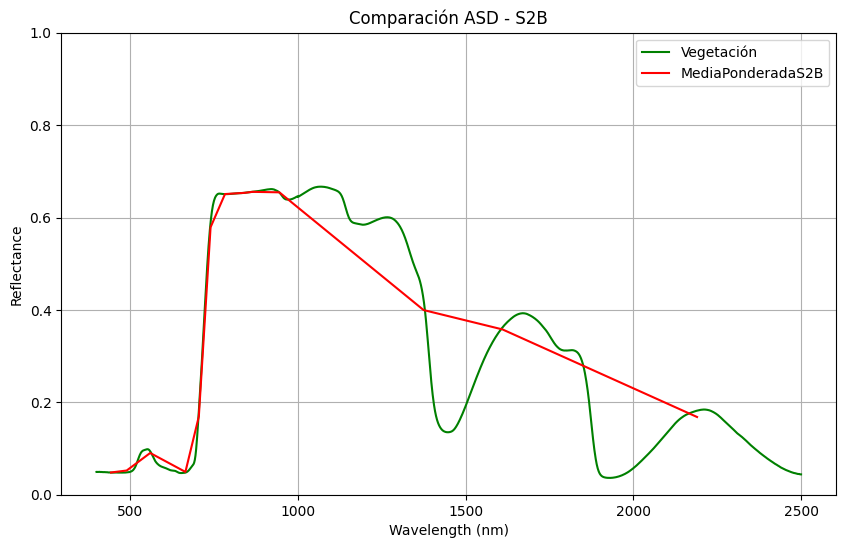

,MediaPonderadaS2B,Wavelength
B1,0.048110,443
B2,0.052398,490
B3,0.090329,560
B4,0.049384,665
B5,0.169295,705
B6,0.578942,740
B7,0.650820,783
B8,0.653441,842
B8A,0.655573,865
B9,0.654545,945


In [6]:
#Paths. Inputs could be both .txt and .asd files
sensores_table = '/home/diego/git/Netops_Cadiz/spectral_response/sensores_srs.xlsx' #ruta al xlsx
spec_path_asd = "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_ASD/2024_06_04/curso00007.asd"
spec_path_txt = "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_TXT/2024_06_04/curso00007.asd.txt"

a = asd(sensores_table, spec_path_asd, 'S2B')
a.spec2sat(spec_path_asd, "Vegetación", plot=True)

## Plot several spectrums and satellite expected bands values together

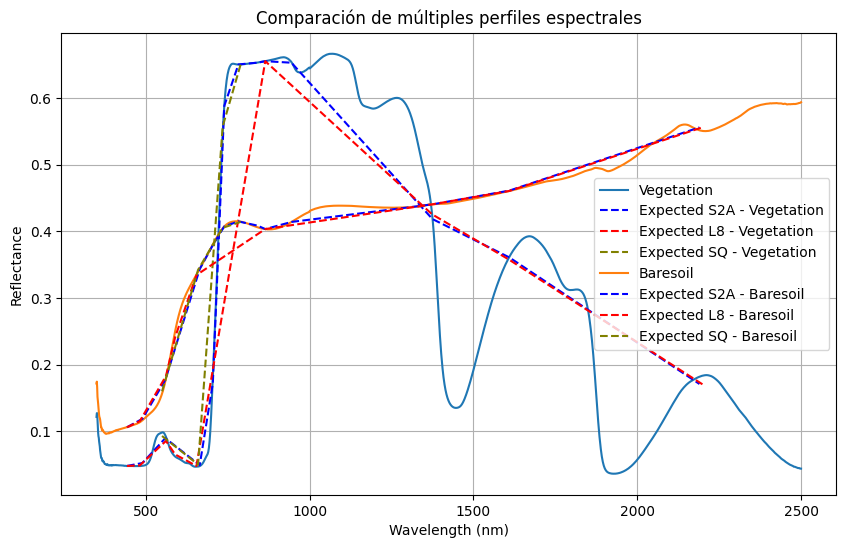

In [4]:
#We can create a spectral list with several spectral to plot all them together in one graphic allongside with the spectral response expected for a list of selected satellites
spec_list_txt = ["/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_TXT/2024_06_04/curso00007.asd.txt", 
             "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_TXT/2024_06_04/curso00001.asd.txt",
             "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_TXT/2024_06_04/curso00011.asd.txt"]

spec_list_asd = ["/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_ASD/2024_06_04/curso00007.asd", 
             "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_ASD/2024_06_04/curso00001.asd",
             "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_ASD/2024_06_04/curso00011.asd"]

#If you want to use this graphic with just one spectrum (maybe you better could use spec2sat) then create a list with just one spectrum
spec_path_asd1l = ["/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_ASD/2024_06_04/curso00007.asd"]

# Create a list with the satellites you want to see their response allong with the spectrums
sats_to_plot = ["S2A", "L8", "SQ"]

# Call the function (here also slicing the list to plot the first 2 specs)
a.plotSpecs(spec_list_asd[:2], names=["Vegetation", "Baresoil"], plot_expected=True, sats=sats_to_plot)

## Export csv files with combination values for all satellites and spectrums

In [ ]:
output_dir = "/home/diego/Desktop/test"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

specs_path = "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_TXT/2024_06_04"
# Crear una instancia de la clase asd
a = asd(sensores=sensores_table, spec_path=specs_path, sat="L8")

# Crear una tabla con la respuesta de todos los espectros para el satélite especificado
a.satTable(output_path="/home/diego/Desktop/test/satellite_response10.csv")

# Crear tablas con los valores de todos los satélites para cada espectro
a.specsTable(output_dir="/home/diego/Desktop/test")

## Computing a normalized difference index between 2 parts of the asd spectrum and its satellite bands equivalents

In [5]:
# Select the profile
veg = "/media/diego/Datos4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_ASD/2024_06_04/curso00007.asd"

# Define the wavelengths to use. Please use this format providing the name of the wavelength area, and the minimum and maximum threshold to use
b1 = ['Nir', 850, 880]
b2 = ['Red', 630, 650]

# Calcular el NDI
ndi_values = a.ndiCalc(veg, b1, b2)
#print(f"NDI values: {ndi_values.items()}")
for k, v in ndi_values.items():
    print(k, v)

Espectro 0.8570972690692517
S2A 0.8594644487037724
S2B 0.8594696449260169
L8 0.8633617481837413
L9 0.8633992511530486
L7 0.8534241371472991
L5 0.8527553146976814
L4 0.8530774013684437
SQ 0.8570972690692517
